In [1]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.multiplex_utils import multiplex_preprocess

In [2]:
# create folder for this set of experiments
experiment_folder = "nuclear_model_DNA"
MODEL_DIR = os.path.join("/data/analyses", experiment_folder)
NPZ_DIR = "/data/npz_data/20201018_freeze/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [ ]:
from deepcell.model_zoo.panopticnet import PanopticNet
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler
from deepcell import image_generators
from deepcell.utils import train_utils
from tensorflow.python.keras.losses import MSE
from deepcell import losses
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

for seed in [1, 2, 3]:
    print("Training model for {}".format(seed))
    npz_name = "20201018_multiplex_seed_{}_nuclear_".format(seed)

    train_dict = np.load(NPZ_DIR + npz_name + "train_512x512.npz", allow_pickle=True)
    val_dict = np.load(NPZ_DIR + npz_name + "val_256x256.npz", allow_pickle=True)
    
    # initialize new model
    new_model = PanopticNet(
        backbone='resnet50',
        input_shape=(256, 256, 1),
        norm_method=None,
        num_semantic_heads=2,
        num_semantic_classes=[1, 3], # inner distance, pixelwise
        location=True,  # should always be true
        include_top=True,
        use_imagenet=True)
    
    
    X_train = train_dict['X'][..., :1]
    y_train = train_dict['y'][..., 1:]
    print("X_train shape is {}, y_train shape is {}".format(X_train.shape, y_train.shape))
    
    
    X_val = val_dict['X'][..., :1]
    y_val = val_dict['y'][..., 1:]
    print("X_val shape is {}, y_val shape is {}".format(X_val.shape, y_val.shape))
        
    # set up training parameters
    model_name = npz_name
    n_epoch = 100  # Number of training epochs

    optimizer = Adam(lr=1e-4, clipnorm=0.001)
    lr_sched = rate_scheduler(lr=1e-4, decay=0.99)

    batch_size = 8

    min_objects = 0  # throw out images with fewer than this many objects
    seed=0
    print("Model name is {}".format(model_name))
    
    # create augmented dataset
    datagen = image_generators.CroppingDataGenerator(
        rotation_range=180,
        shear_range=0,
        zoom_range=(0.7, 1/0.7),
        horizontal_flip=True,
        vertical_flip=True,
        crop_size=(256, 256),
        float_dtype='float16',
        int_dtype='int16')

    datagen_val = image_generators.SemanticDataGenerator(
        rotation_range=0,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=0,
        vertical_flip=0,
        float_dtype='float16',
        int_dtype='int16')

    train_data = datagen.flow(
        {'X': X_train, 'y': y_train},
        seed=seed,
        transforms=['inner-distance', 'pixelwise'],
        transforms_kwargs={'pixelwise':{'dilation_radius': 1}, 
                          'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
        min_objects=min_objects,
        batch_size=batch_size)

    val_data = datagen_val.flow(
        {'X': X_val, 'y': y_val},
        seed=seed,
        transforms=['inner-distance', 'pixelwise'],
        transforms_kwargs={'pixelwise':{'dilation_radius': 1},
                          'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
        min_objects=min_objects,
        batch_size=batch_size)
    
    print('generators created')
    
    # set up losses
    def semantic_loss(n_classes):
        def _semantic_loss(y_pred, y_true):
            if n_classes > 1:
                return 0.01 * losses.weighted_categorical_crossentropy(
                    y_pred, y_true, n_classes=n_classes)
            return MSE(y_pred, y_true)
        return _semantic_loss


    loss = {}

    # Give losses for all of the semantic heads
    for layer in new_model.layers:
        if layer.name.startswith('semantic_'):
            n_classes = layer.output_shape[-1]
            loss[layer.name] = semantic_loss(n_classes)
            
    # compile model
    new_model.compile(loss=loss, optimizer=optimizer)
    
    # train model
    model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
    loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

    num_gpus = count_gpus()

    print('Training on', num_gpus, 'GPUs.')

    train_callbacks = get_callbacks(
        model_path,
        lr_sched=lr_sched,
        #tensorboard_log_dir=LOG_DIR,
        save_weights_only=num_gpus >= 2,
        monitor='val_loss',
        verbose=1)

    loss_history = new_model.fit_generator(
        train_data,
        steps_per_epoch=333,
        epochs=n_epoch,
        validation_data=val_data,
        validation_steps=val_data.y.shape[0] // batch_size,
        callbacks=train_callbacks)


Training model for 1
X_train shape is (2664, 512, 512, 1), y_train shape is (2664, 512, 512, 1)


W1205 03:53:49.134928 140147212359488 semantic.py:111] X data dtype is float32: this will increase memory use during preprocessing. Consider using a smaller dtype
W1205 03:53:49.135730 140147212359488 semantic.py:115] y data dtype is int32: this will increase memory use during preprocessing. Consider using a smaller dtype.


X_val shape is (3224, 256, 256, 1), y_val shape is (3224, 256, 256, 1)
Model name is 20201018_multiplex_seed_1_nuclear_


W1205 04:00:09.072715 140147212359488 semantic.py:111] X data dtype is float32: this will increase memory use during preprocessing. Consider using a smaller dtype
W1205 04:00:09.074001 140147212359488 semantic.py:115] y data dtype is int32: this will increase memory use during preprocessing. Consider using a smaller dtype.


generators created
Training on 1 GPUs.
Epoch 1/100
332/333 [============================>.] - ETA: 0s - loss: 0.0296 - semantic_0_loss: 0.0238 - semantic_1_loss: 0.0057
Epoch 00001: val_loss improved from inf to 0.08146, saving model to /data/analyses/nuclear_model_DNA/20201018_multiplex_seed_1_nuclear_.h5
333/333 [==============================] - 204s 612ms/step - loss: 0.0295 - semantic_0_loss: 0.0238 - semantic_1_loss: 0.0057 - val_loss: 0.0815 - val_semantic_0_loss: 0.0354 - val_semantic_1_loss: 0.0461
Epoch 2/100
332/333 [============================>.] - ETA: 0s - loss: 0.0121 - semantic_0_loss: 0.0082 - semantic_1_loss: 0.0039
Epoch 00002: val_loss improved from 0.08146 to 0.04873, saving model to /data/analyses/nuclear_model_DNA/20201018_multiplex_seed_1_nuclear_.h5
333/333 [==============================] - 78s 235ms/step - loss: 0.0121 - semantic_0_loss: 0.0082 - semantic_1_loss: 0.0039 - val_loss: 0.0487 - val_semantic_0_loss: 0.0256 - val_semantic_1_loss: 0.0231
Epoch 3/10

332/333 [============================>.] - ETA: 0s - loss: 0.0079 - semantic_0_loss: 0.0051 - semantic_1_loss: 0.0029
Epoch 00020: val_loss did not improve from 0.00563
333/333 [==============================] - 75s 224ms/step - loss: 0.0079 - semantic_0_loss: 0.0051 - semantic_1_loss: 0.0029 - val_loss: 0.2655 - val_semantic_0_loss: 0.2633 - val_semantic_1_loss: 0.0023
Epoch 21/100
332/333 [============================>.] - ETA: 0s - loss: 0.0079 - semantic_0_loss: 0.0050 - semantic_1_loss: 0.0029
Epoch 00021: val_loss did not improve from 0.00563
333/333 [==============================] - 74s 222ms/step - loss: 0.0078 - semantic_0_loss: 0.0050 - semantic_1_loss: 0.0029 - val_loss: 0.0059 - val_semantic_0_loss: 0.0036 - val_semantic_1_loss: 0.0023
Epoch 22/100
332/333 [============================>.] - ETA: 0s - loss: 0.0078 - semantic_0_loss: 0.0050 - semantic_1_loss: 0.0029
Epoch 00022: val_loss did not improve from 0.00563
333/333 [==============================] - 74s 221ms/step -

332/333 [============================>.] - ETA: 0s - loss: 0.0072 - semantic_0_loss: 0.0045 - semantic_1_loss: 0.0027
Epoch 00041: val_loss did not improve from 0.00547
333/333 [==============================] - 73s 219ms/step - loss: 0.0072 - semantic_0_loss: 0.0045 - semantic_1_loss: 0.0027 - val_loss: 0.0058 - val_semantic_0_loss: 0.0036 - val_semantic_1_loss: 0.0022
Epoch 42/100
332/333 [============================>.] - ETA: 0s - loss: 0.0072 - semantic_0_loss: 0.0045 - semantic_1_loss: 0.0027
Epoch 00042: val_loss did not improve from 0.00547
333/333 [==============================] - 74s 221ms/step - loss: 0.0072 - semantic_0_loss: 0.0045 - semantic_1_loss: 0.0027 - val_loss: 0.0718 - val_semantic_0_loss: 0.0694 - val_semantic_1_loss: 0.0024
Epoch 43/100
332/333 [============================>.] - ETA: 0s - loss: 0.0073 - semantic_0_loss: 0.0046 - semantic_1_loss: 0.0027
Epoch 00043: val_loss did not improve from 0.00547
333/333 [==============================] - 73s 221ms/step -

332/333 [============================>.] - ETA: 0s - loss: 0.0071 - semantic_0_loss: 0.0045 - semantic_1_loss: 0.0027
Epoch 00061: val_loss did not improve from 0.00525
333/333 [==============================] - 72s 216ms/step - loss: 0.0071 - semantic_0_loss: 0.0045 - semantic_1_loss: 0.0027 - val_loss: 0.0935 - val_semantic_0_loss: 0.0914 - val_semantic_1_loss: 0.0021
Epoch 62/100
332/333 [============================>.] - ETA: 0s - loss: 0.0070 - semantic_0_loss: 0.0044 - semantic_1_loss: 0.0026
Epoch 00062: val_loss did not improve from 0.00525
333/333 [==============================] - 73s 219ms/step - loss: 0.0070 - semantic_0_loss: 0.0044 - semantic_1_loss: 0.0026 - val_loss: 0.0058 - val_semantic_0_loss: 0.0035 - val_semantic_1_loss: 0.0023
Epoch 63/100
332/333 [============================>.] - ETA: 0s - loss: 0.0070 - semantic_0_loss: 0.0044 - semantic_1_loss: 0.0026
Epoch 00063: val_loss did not improve from 0.00525
333/333 [==============================] - 72s 218ms/step -

332/333 [============================>.] - ETA: 0s - loss: 0.0069 - semantic_0_loss: 0.0043 - semantic_1_loss: 0.0026
Epoch 00082: val_loss did not improve from 0.00525
333/333 [==============================] - 72s 216ms/step - loss: 0.0069 - semantic_0_loss: 0.0043 - semantic_1_loss: 0.0026 - val_loss: 0.0055 - val_semantic_0_loss: 0.0033 - val_semantic_1_loss: 0.0021
Epoch 83/100
332/333 [============================>.] - ETA: 0s - loss: 0.0068 - semantic_0_loss: 0.0042 - semantic_1_loss: 0.0026
Epoch 00083: val_loss did not improve from 0.00525
333/333 [==============================] - 72s 217ms/step - loss: 0.0068 - semantic_0_loss: 0.0042 - semantic_1_loss: 0.0026 - val_loss: 0.0054 - val_semantic_0_loss: 0.0033 - val_semantic_1_loss: 0.0021
Epoch 84/100
332/333 [============================>.] - ETA: 0s - loss: 0.0069 - semantic_0_loss: 0.0043 - semantic_1_loss: 0.0026
Epoch 00084: val_loss did not improve from 0.00525
333/333 [==============================] - 73s 218ms/step -

W1205 06:11:08.154672 140147212359488 semantic.py:111] X data dtype is float32: this will increase memory use during preprocessing. Consider using a smaller dtype
W1205 06:11:08.156269 140147212359488 semantic.py:115] y data dtype is int32: this will increase memory use during preprocessing. Consider using a smaller dtype.


X_val shape is (3284, 256, 256, 1), y_val shape is (3284, 256, 256, 1)
Model name is 20201018_multiplex_seed_2_nuclear_


W1205 06:17:16.651424 140147212359488 semantic.py:111] X data dtype is float32: this will increase memory use during preprocessing. Consider using a smaller dtype
W1205 06:17:17.023623 140147212359488 semantic.py:115] y data dtype is int32: this will increase memory use during preprocessing. Consider using a smaller dtype.


generators created
Training on 1 GPUs.
Epoch 1/100
332/333 [============================>.] - ETA: 0s - loss: 0.0199 - semantic_0_loss: 0.0144 - semantic_1_loss: 0.0056
Epoch 00001: val_loss improved from inf to 0.12864, saving model to /data/analyses/nuclear_model_DNA/20201018_multiplex_seed_2_nuclear_.h5
333/333 [==============================] - 254s 763ms/step - loss: 0.0199 - semantic_0_loss: 0.0144 - semantic_1_loss: 0.0055 - val_loss: 0.1286 - val_semantic_0_loss: 0.0351 - val_semantic_1_loss: 0.0935
Epoch 2/100
332/333 [============================>.] - ETA: 0s - loss: 0.0124 - semantic_0_loss: 0.0084 - semantic_1_loss: 0.0040
Epoch 00002: val_loss improved from 0.12864 to 0.04983, saving model to /data/analyses/nuclear_model_DNA/20201018_multiplex_seed_2_nuclear_.h5
333/333 [==============================] - 82s 245ms/step - loss: 0.0124 - semantic_0_loss: 0.0084 - semantic_1_loss: 0.0040 - val_loss: 0.0498 - val_semantic_0_loss: 0.0286 - val_semantic_1_loss: 0.0212
Epoch 3/10

332/333 [============================>.] - ETA: 0s - loss: 0.0080 - semantic_0_loss: 0.0051 - semantic_1_loss: 0.0029
Epoch 00020: val_loss improved from 0.00592 to 0.00585, saving model to /data/analyses/nuclear_model_DNA/20201018_multiplex_seed_2_nuclear_.h5
333/333 [==============================] - 84s 254ms/step - loss: 0.0080 - semantic_0_loss: 0.0051 - semantic_1_loss: 0.0029 - val_loss: 0.0059 - val_semantic_0_loss: 0.0036 - val_semantic_1_loss: 0.0022
Epoch 21/100
332/333 [============================>.] - ETA: 0s - loss: 0.0078 - semantic_0_loss: 0.0050 - semantic_1_loss: 0.0029
Epoch 00021: val_loss improved from 0.00585 to 0.00578, saving model to /data/analyses/nuclear_model_DNA/20201018_multiplex_seed_2_nuclear_.h5
333/333 [==============================] - 85s 254ms/step - loss: 0.0078 - semantic_0_loss: 0.0050 - semantic_1_loss: 0.0029 - val_loss: 0.0058 - val_semantic_0_loss: 0.0035 - val_semantic_1_loss: 0.0023
Epoch 22/100
332/333 [============================>.] - E

In [6]:
y_train.dtype

dtype('int32')

In [4]:
from deepcell.model_zoo.panopticnet import PanopticNet
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler
from deepcell import image_generators
from deepcell.utils import train_utils
from tensorflow.python.keras.losses import MSE
from deepcell import losses
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

# npz_name = "20201018_multiplex_seed_3_"

# val_dict = np.load(NPZ_DIR + npz_name + "val_256x256.npz", allow_pickle=True)

# # initialize new model
# new_model = PanopticNet(
#     backbone='resnet50',
#     input_shape=(256, 256, 2),
#     norm_method=None,
#     num_semantic_heads=2,
#     num_semantic_classes=[1, 3], # inner distance, pixelwise
#     location=True,  # should always be true
#     include_top=True,
#     use_imagenet=True)

# new_model.load_weights(os.path.join(MODEL_DIR, npz_name + 'dropout_toolbox_normalize.h5'))

# X_val = val_dict['X']
# # X_val = multiplex_preprocess(X_val)
# X_val = normalize(X_val)
# y_val = val_dict['y']
# print("X_val shape is {}, y_val shape is {}".format(X_val.shape, y_val.shape))

interior, pixelwise = new_model.predict(X_val[:100])
        


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  This is separate from the ipykernel package so we can avoid doing imports until


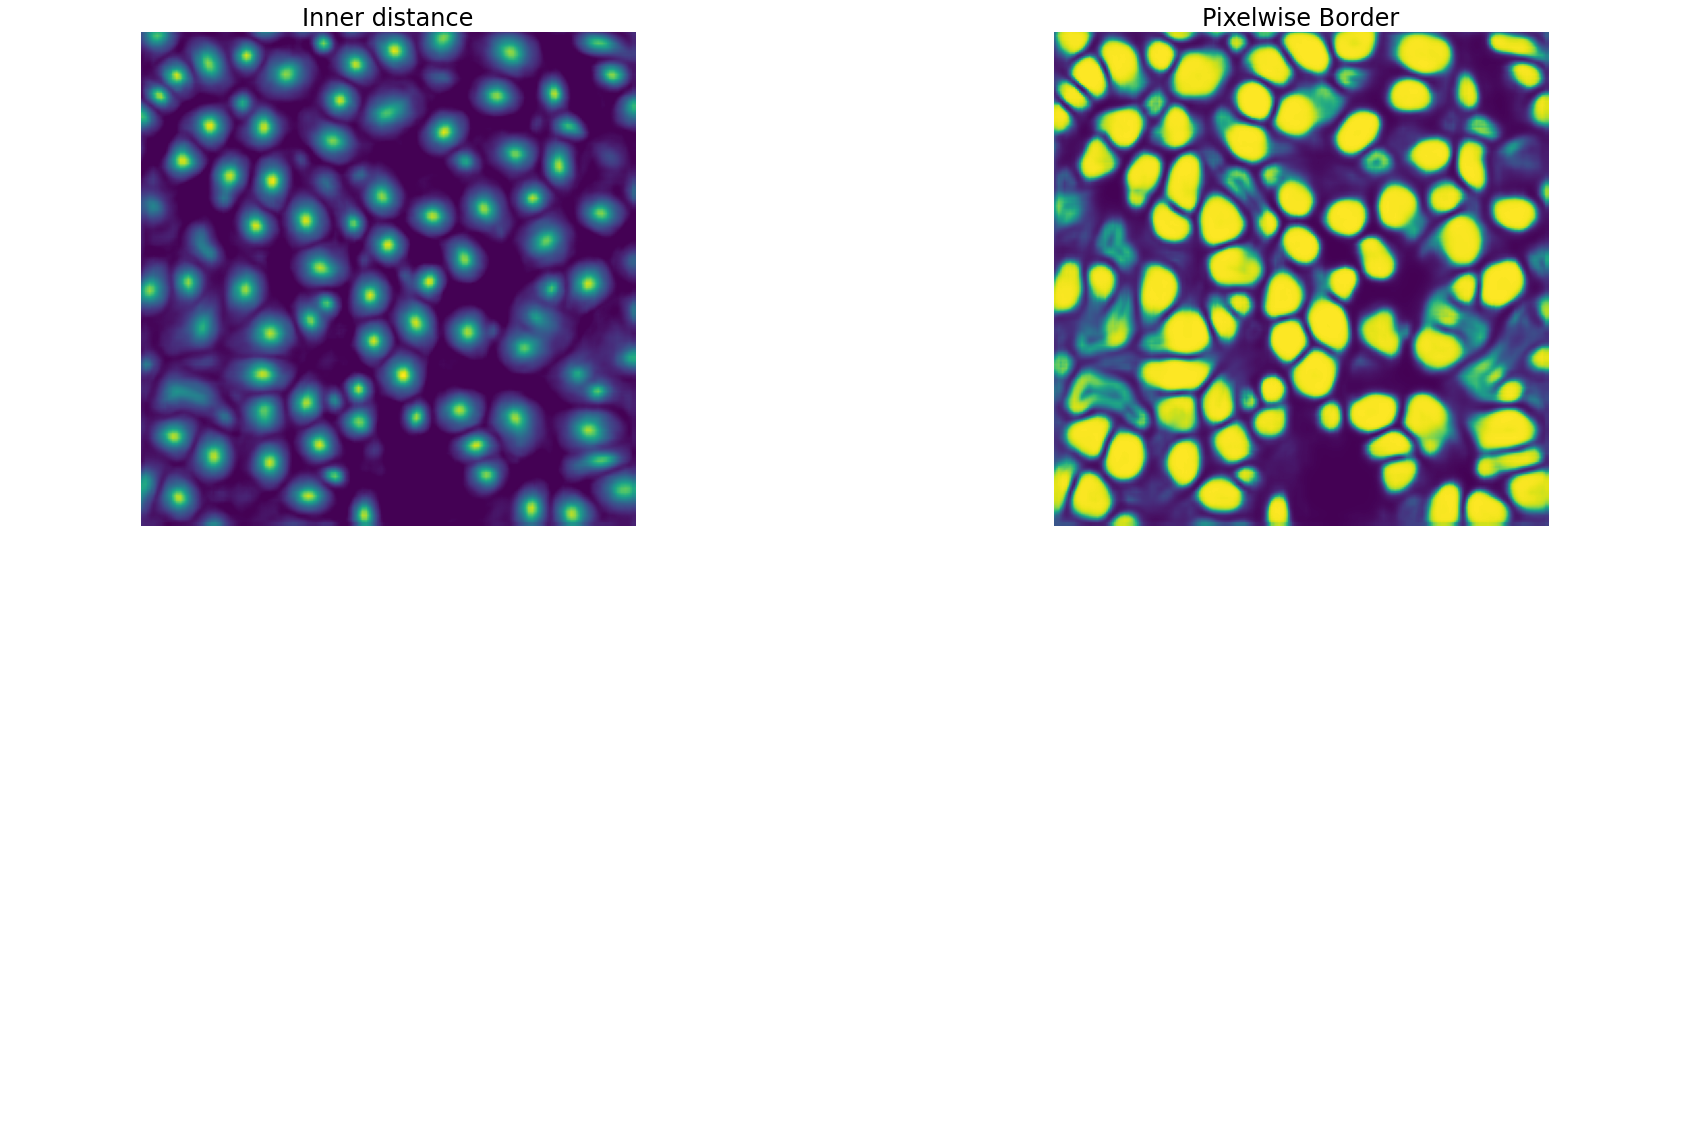

In [5]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 30
fig, axes = plt.subplots(2,2,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(interior[index,...,0].astype('float32'))
axes[1].imshow(pixelwise[index,...,1].astype('float32'))
#axes[2].imshow(predicted_overlay[index, ...], cmap=cmap)
#axes[3].imshow(true_overlay[index, ...], cmap=cmap)

axes[0].set_title('Inner distance', fontsize=24)
axes[1].set_title('Pixelwise Border', fontsize=24)
#axes[2].set_title('Predicted Overlay', fontsize=24)
#axes[3].set_title('True Overlay', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()